# Florida Panthers - Event Propensity
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* December 8, 2021

## Hypothesis
There are features in our ticketing and marketing datasets that may help predict if a fan has high potential to purchase a single game ticket. We will select these features and test the model metrics for prediction.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [2]:
import getpass
import pyodbc
import pandas as pd
import warnings

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [3]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [4]:
lkupclientid = 93 # Florida Panthers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrNHLPanthers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(15940, 55)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15940 entries, 0 to 15939
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              15940 non-null  int64  
 1   dimCustomerMasterId       15940 non-null  int64  
 2   customerNumber            15940 non-null  object 
 3   year                      15940 non-null  object 
 4   productGrouping           15940 non-null  object 
 5   totalSpent                15940 non-null  float64
 6   recentDate                15940 non-null  object 
 7   attendancePercent         15940 non-null  float64
 8   renewedBeforeDays         15940 non-null  int64  
 9   isBuyer                   15940 non-null  object 
 10  source_tenure             15940 non-null  int64  
 11  tenure                    15940 non-null  int64  
 12  distToVenue               0 non-null      object 
 13  totalGames                15940 non-null  int64  
 14  recenc

### Let's drop the features that have lots of null values, and any ID columns, as these won't be useful to our model:

In [6]:
df.drop([
    'distToVenue',
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity', 
    'isnextyear_buyer', 
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.shape

(15940, 46)

### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [7]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(15940, 28)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [8]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15940 entries, 0 to 15939
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  15940 non-null  int64  
 1   attendancePercent    15940 non-null  float64
 2   renewedBeforeDays    15940 non-null  int64  
 3   source_tenure        15940 non-null  int64  
 4   tenure               15940 non-null  int64  
 5   totalGames           15940 non-null  int64  
 6   recency              15940 non-null  int64  
 7   missed_games_1       15940 non-null  int64  
 8   missed_games_2       15940 non-null  int64  
 9   missed_games_over_2  15940 non-null  int64  
 10  click_link           15940 non-null  int64  
 11  open_email           15940 non-null  int64  
 12  send_email           15940 non-null  int64  
 13  email                15940 non-null  int64  
 14  phonecall            15940 non-null  int64  
 15  isNextYear_Buyer     15940 non-null 

### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [9]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,attendancePercent,renewedBeforeDays,source_tenure,tenure,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,click_link,open_email,send_email,email,phonecall,isNextYear_Buyer
dimCustomerMasterId,1.00,-0.04,-0.08,-0.06,-0.07,-0.07,-0.01,-0.06,-0.02,-0.01,-0.04,-0.06,-0.09,-0.01,0.11,-0.06
attendancePercent,-0.04,1.00,-0.14,-0.09,-0.13,0.36,-0.22,0.03,-0.08,-0.33,-0.08,-0.08,-0.12,-0.04,0.10,-0.14
renewedBeforeDays,-0.08,-0.14,1.00,0.17,0.32,0.10,-0.01,0.14,0.08,0.03,-0.07,-0.04,-0.09,0.06,-0.02,0.10
source_tenure,-0.06,-0.09,0.17,1.00,0.27,0.15,0.00,0.11,0.12,0.12,0.08,0.10,0.06,-0.04,-0.12,0.23
tenure,-0.07,-0.13,0.32,0.27,1.00,-0.13,-0.04,-0.10,-0.06,-0.06,0.19,0.19,0.19,0.19,0.13,-0.10
totalGames,-0.07,0.36,0.10,0.15,-0.13,1.00,-0.12,0.55,0.33,0.12,0.01,0.05,0.13,-0.11,-0.20,0.41
recency,-0.01,-0.22,-0.01,0.00,-0.04,-0.12,1.00,-0.02,0.07,0.24,-0.04,-0.04,0.01,-0.02,-0.03,-0.06
missed_games_1,-0.06,0.03,0.14,0.11,-0.10,0.55,-0.02,1.00,0.37,0.11,-0.04,0.01,0.09,-0.08,-0.17,0.26
missed_games_2,-0.02,-0.08,0.08,0.12,-0.06,0.33,0.07,0.37,1.00,0.31,-0.06,-0.02,0.04,-0.07,-0.11,0.16
missed_games_over_2,-0.01,-0.33,0.03,0.12,-0.06,0.12,0.24,0.11,0.31,1.00,-0.07,-0.03,0.04,-0.07,-0.10,0.13


### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [10]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (12752, 16)
Unseen Data For Predictions: (3188, 16)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [11]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=["dimCustomerMasterId"],
    numeric_features=[
        "attendancePercent",
        "click_link",
        "email",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "open_email",
        "phonecall",
        "recency",
        "renewedBeforeDays",
        "send_email",
        "source_tenure",
        "tenure",
        "totalGames"
    ]
);

In [12]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.8180,0.8973,0.8739,0.7877,0.8284,0.6357,0.6398,0.0350
7,Random Forest Classifier,0.8118,0.8898,0.8671,0.7824,0.8225,0.6233,0.6271,0.2010
9,Extreme Gradient Boosting,0.8113,0.8910,0.8536,0.7889,0.8199,0.6224,0.6247,0.4710
2,Gradient Boosting Classifier,0.8110,0.8915,0.8667,0.7815,0.8218,0.6217,0.6257,0.1570
3,Extra Trees Classifier,0.8071,0.8848,0.8602,0.7794,0.8177,0.6139,0.6175,0.1820
0,Ada Boost Classifier,0.7989,0.8816,0.8530,0.7716,0.8102,0.5976,0.6011,0.1830
8,NGBClassifier,0.7906,0.8689,0.8671,0.7538,0.8064,0.5808,0.5877,1.9990
6,Logistic Regression,0.7544,0.8429,0.7565,0.7556,0.7560,0.5088,0.5090,0.1780
4,K Neighbors Classifier,0.7487,0.8102,0.7918,0.7310,0.7601,0.4970,0.4990,0.0350
1,Decision Tree Classifier,0.7444,0.7446,0.7355,0.7512,0.7432,0.4889,0.4891,0.0150


### The top model is performing well, so let's compare it against our unseen eval dataset:

In [13]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8443,0.9155,0.8986,0.8116,0.8529,0.6884,0.6924
1,0.8127,0.8917,0.8635,0.7855,0.8227,0.6253,0.6284
2,0.8245,0.9091,0.8752,0.7961,0.8338,0.6488,0.6521
3,0.7971,0.8872,0.8538,0.7684,0.8089,0.5938,0.5976
4,0.8314,0.9012,0.8674,0.8106,0.8380,0.6626,0.6643
5,0.8216,0.9006,0.8772,0.7909,0.8318,0.6429,0.6468
6,0.8255,0.9039,0.8791,0.7954,0.8352,0.6508,0.6544
7,0.8147,0.9017,0.9025,0.7691,0.8305,0.6290,0.6388
8,0.7990,0.8788,0.8655,0.7655,0.8124,0.5977,0.6029
9,0.8088,0.8834,0.8558,0.7839,0.8183,0.6174,0.6201


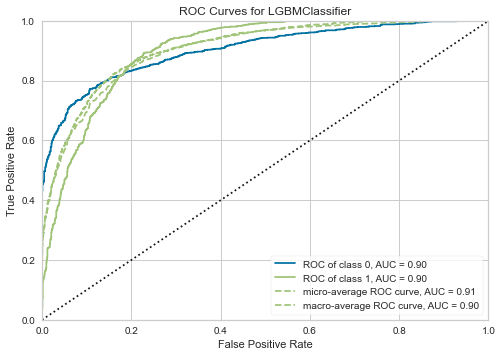

In [14]:
plot_model(best_model, plot='auc')

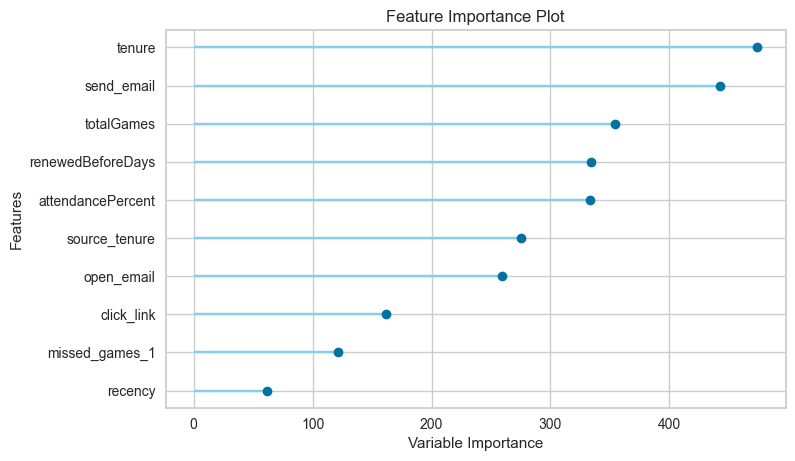

In [15]:
plot_model(best_model, plot='feature')

In [ ]:
plot_model(best_model, plot='confusion_matrix')

## Results

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?